In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper,BravyiKitaevMapper
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import spsa

In [2]:
n = 4
N = 2*n
t=1
mu=1.5
U=3

In [3]:
op = FermionicOp(
    {
        "+_0 -_0": 1.0,
        "+_1 -_1": -1.0,
    },
    num_spin_orbitals=2,
)

In [4]:
print(op)

Fermionic Operator
number spin orbitals=2, number terms=2
  1.0 * ( +_0 -_0 )
+ -1.0 * ( +_1 -_1 )


In [5]:
def qOp(i,j):
    return FermionicOp(
    {
        "+_{i} -_{j}".format(i=i%N,j=j%N): 1.0,
    },
    num_spin_orbitals=N,
)

In [6]:
t_list = []
U_list = []
for i in range(n):
    t_list.append((2*i,(2*i+2)%N))
    t_list.append((2*i+1,(2*i+3)%N))
site_list = [2*i for i in range(n)]

t_term = 0
U_term = 0
mu_term = 0

for edge in t_list:
    t_term += qOp(edge[0],edge[1])
    t_term += qOp(edge[1],edge[0])

for u in site_list:
    mu_term += qOp(u,u) + qOp(u+1,u+1)
    U_term += qOp(u,u)@qOp(u+1,u+1)

H = U * U_term - mu * mu_term - t * t_term

print(H)

U_list = [(i,i+1) for i in site_list]

Fermionic Operator
number spin orbitals=8, number terms=28
  3.0 * ( +_0 -_0 +_1 -_1 )
+ 3.0 * ( +_2 -_2 +_3 -_3 )
+ 3.0 * ( +_4 -_4 +_5 -_5 )
+ 3.0 * ( +_6 -_6 +_7 -_7 )
+ -1.5 * ( +_0 -_0 )
+ -1.5 * ( +_1 -_1 )
+ -1.5 * ( +_2 -_2 )
+ -1.5 * ( +_4 -_4 )
+ -1.5 * ( +_6 -_6 )
+ -1.5 * ( +_3 -_3 )
+ -1.5 * ( +_7 -_7 )
+ -1.5 * ( +_5 -_5 )
+ -1.0 * ( +_7 -_5 )
+ -1.0 * ( +_1 -_3 )
+ -1.0 * ( +_4 -_6 )
+ -1.0 * ( +_6 -_0 )
+ -1.0 * ( +_5 -_3 )
+ -1.0 * ( +_7 -_1 )
+ -1.0 * ( +_2 -_4 )
+ -1.0 * ( +_2 -_0 )
+ -1.0 * ( +_0 -_6 )
+ -1.0 * ( +_1 -_7 )
+ -1.0 * ( +_5 -_7 )
+ -1.0 * ( +_6 -_4 )
+ -1.0 * ( +_0 -_2 )
+ -1.0 * ( +_4 -_2 )
+ -1.0 * ( +_3 -_1 )
+ -1.0 * ( +_3 -_5 )


In [7]:
mapper = JordanWignerMapper()
qubit_jw_op = mapper.map(H)
print(qubit_jw_op)

SparsePauliOp(['IIIIIIII', 'IIIIIIZZ', 'IIIIZZII', 'IIZZIIII', 'ZZIIIIII', 'XZXIIIII', 'YZYIIIII', 'IIIIYZYI', 'IIIIXZXI', 'IYZYIIII', 'IXZXIIII', 'IXZZZZZX', 'IYZZZZZY', 'IIXZXIII', 'IIYZYIII', 'XZZZZZXI', 'YZZZZZYI', 'IIIYZYII', 'IIIXZXII', 'IIIIIXZX', 'IIIIIYZY'],
              coeffs=[-3.  +0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j,  0.75+0.j, -0.5 +0.j,
 -0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.5 +0.j,
 -0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.5 +0.j, -0.5 +0.j,
 -0.5 +0.j, -0.5 +0.j, -0.5 +0.j])


In [8]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(N)

In [9]:
from qiskit.providers.fake_provider import GenericBackendV2

# To run on hardware, select the backend with the fewest number of jobs in the queue
backend = GenericBackendV2(num_qubits=N)
print(backend)

In [10]:
#cost dict
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def reset():
    cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
#cost func
def cost_func(params, ansatz, hamiltonian, estimator):
    
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    if cost_history_dict['iters']%50 == 0:
        print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2


class VQE:

    def __init__(self,backend,ansatz, cost_f, x0 = None, optimizer = "cobyla",estimator = None,shots = 1024):
        #backend
        self.backend = backend
        #transpiled ansatz
        self.num_params = ansatz.num_parameters
        self.ansatz = ansatz
        self.pm_ansatz = None
        #self.ansatz = ansatz
        #optimizer
        self.optimizer = optimizer
        #estimator
        if estimator is not None:
            self.estimator = estimator
        else:
            estimator = BackendEstimatorV2(backend=backend)
            estimator.options.default_shots = shots
            self.estimator = estimator
        #cost
        self.cost_f = cost_f
        if x0 is None:
            x0 = 2 * np.pi * np.random.random(self.num_params)
        self.x0 = x0

    def pass_manage_ansatz(self):
        self.num_params = self.ansatz.num_parameters
        target = self.backend.target
        pm = generate_preset_pass_manager(target=target, optimization_level=3)
        self.pm_ansatz = pm.run(self.ansatz)

    def compute_minimum_eigenvalue(self,hamiltonian,aux_operators = [],maxiter = 500):
        #hamiltonian
        self.pass_manage_ansatz()
        print("Running with",self.pm_ansatz.num_parameters, "parameters")
        print("Running with the following ansatz:")
        hamiltonian_isa = hamiltonian.apply_layout(layout=self.pm_ansatz.layout)
        for i,op in enumerate(aux_operators):
            aux_operators[i] = op.apply_layout(layout=self.pm_ansatz.layout)
        res = minimize(
        self.cost_f,
        self.x0,
        args=(self.pm_ansatz, hamiltonian_isa, self.estimator),
        method=self.optimizer,
        options = {"maxiter": maxiter}
        )
        
        return res


In [12]:
def spsa_min(f,x0,args,*arg,**kwargs):
    ansatz, hamiltonian, estimator = args
    def new_cost(x):
        return f(x,ansatz,hamiltonian,estimator)
    xx = spsa.minimize(new_cost,x0,iterations=kwargs['maxiter'])
    return xx

In [13]:
vqe = VQE(backend,ansatz,cost_func,optimizer='cobyla')

In [14]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
res = vqe.compute_minimum_eigenvalue(hamiltonian = qubit_jw_op)

Running with 64 parameters
Running with the following ansatz:


/Users/batuyalcin/anaconda3/envs/QiskitNew/lib/python3.11/site-packages/qiskit/providers/fake_provider/generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


Iters. done: 50 [Current cost: -4.1400146484375]
Iters. done: 100 [Current cost: -4.918212890625]
Iters. done: 150 [Current cost: -5.2530517578125]
Iters. done: 200 [Current cost: -5.6558837890625]
Iters. done: 250 [Current cost: -5.89990234375]
Iters. done: 300 [Current cost: -6.125244140625]
Iters. done: 350 [Current cost: -6.1685791015625]
Iters. done: 400 [Current cost: -6.15771484375]
Iters. done: 450 [Current cost: -6.2852783203125]
Iters. done: 500 [Current cost: -6.2113037109375]


In [15]:
import scipy.sparse as sp

ham_mat = qubit_jw_op.to_matrix(sparse = True)
eig = np.real(sp.linalg.eigs(ham_mat,k=1,return_eigenvectors=False))
print(eig)

[-8.4244289]


In [16]:
print(res.fun)

-6.316650390625


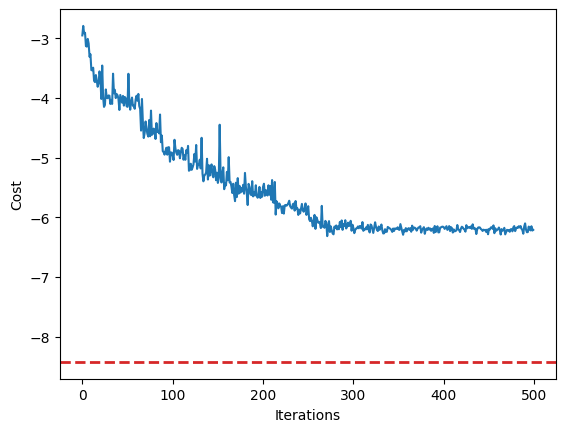

In [17]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.axhline(y=eig, color="tab:red", ls="--", lw=2, label="Target: " + str(eig))
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [18]:
from qiskit.circuit.library import SwapGate, ExcitationPreserving
from scipy.linalg import expm
from qiskit.quantum_info import Operator, Clifford, Pauli, PauliList, SparsePauliOp
from qiskit.circuit.library import EvolvedOperatorAnsatz, PauliEvolutionGate, HamiltonianGate,UnitaryGate, XXPlusYYGate

#eZZ gate
theta = 0.7809
Smat = SwapGate().to_matrix()
Sop = Operator(SwapGate())
#print(Sop)
#expS = expm(1j*Smat)
#def expSt(t):
#    return np.power(expS,t)

def eSwap(circ,i,j,param):
    eSt = HamiltonianGate(Sop,param,label = "eSWAP")
    circ.append(eSt,[i,j])


def eZZ(circ,i,j,t):
    circ.cx(i,j)
    circ.rz(t,j)
    circ.cx(i,j)

def fij(circ,i,j,t):
    circ.append(XXPlusYYGate(t),[i,j])
    circ.cp(t,i,j)


def efSwap(circ,i,j,t):
    for k in range(j-1,i,-1):
        circ.cz(j,k)
    fij(circ,i,j,t)
    for k in range(i+1,j,1):
        circ.cz(j,k)

def hopping(circ,r):
    n = circ.num_qubits
    t_s = ParameterVector("t_h{r}".format(r=r),length = n)
    for i in range(n):
        efSwap(circ,i,(i+2)%n,t_s[i])

def interaction(circ,r):
    n = circ.num_qubits
    t_s = ParameterVector("t_i{r}".format(r=r),length = n//2)
    for i in range(0,n,2):
        eZZ(circ,i,i+1,t_s[i//2])


li = [i for i in range(0,n,4)]+[i+1 for i in range(0,n,4)]
def start(circ):
    n = circ.num_qubits
    for i in li:
        circ.x(i)
        circ.h(i+2)
        circ.cx(i,i+2)
    circ.barrier()

def start2(circ):
    n = circ.num_qubits
    li = [i for i in range(0,n//2,2)]+[n-1-i for i in range(0,n//2,2)]
    circ.x(li)
    circ.barrier()

def makePauliStr(N,idx,gs):
    pauli_str = ""
    for i in range(N):
        if i in idx:
            pauli_str+=gs[idx.index(i)]
        else:
            pauli_str+="I"
    return pauli_str

def ZZ(N,i,j):
    zz_str = makePauliStr(N,(i,j),["Z","Z"])
    return SparsePauliOp([zz_str],coeffs = [.5])

def dZZ(N,i,j,k,l):
    zz_str = makePauliStr(N,(i,j,k,l),["Z","Z","Z","Z"])
    return SparsePauliOp([zz_str],coeffs = [.5])

def XXplusYY(N,i,j):
    xx_str = makePauliStr(N,(i,j),["X","X"])
    yy_str = makePauliStr(N,(i,j),["Y","Y"])
    return SparsePauliOp([xx_str,yy_str],coeffs = [.25,.25])

def dXXplusYY(N,i,j,k,l):
    ij = XXplusYY(N,i,j)
    kl = XXplusYY(N,k,l)
    return ij@kl

def hopint(circ,reps = 3):
    for r in range(reps):
        hopping(circ,r)
        interaction(circ,r)
        #circ.append(EfficientSU2(num_qubits = circ.num_qubits, parameter_prefix="t_e{r}".format(r=r)),[i for i in range(circ.num_qubits)])
    
def hopint1(circ,reps = 3):
    for r in range(reps):
        hopping(circ,r)
        interaction(circ,r)

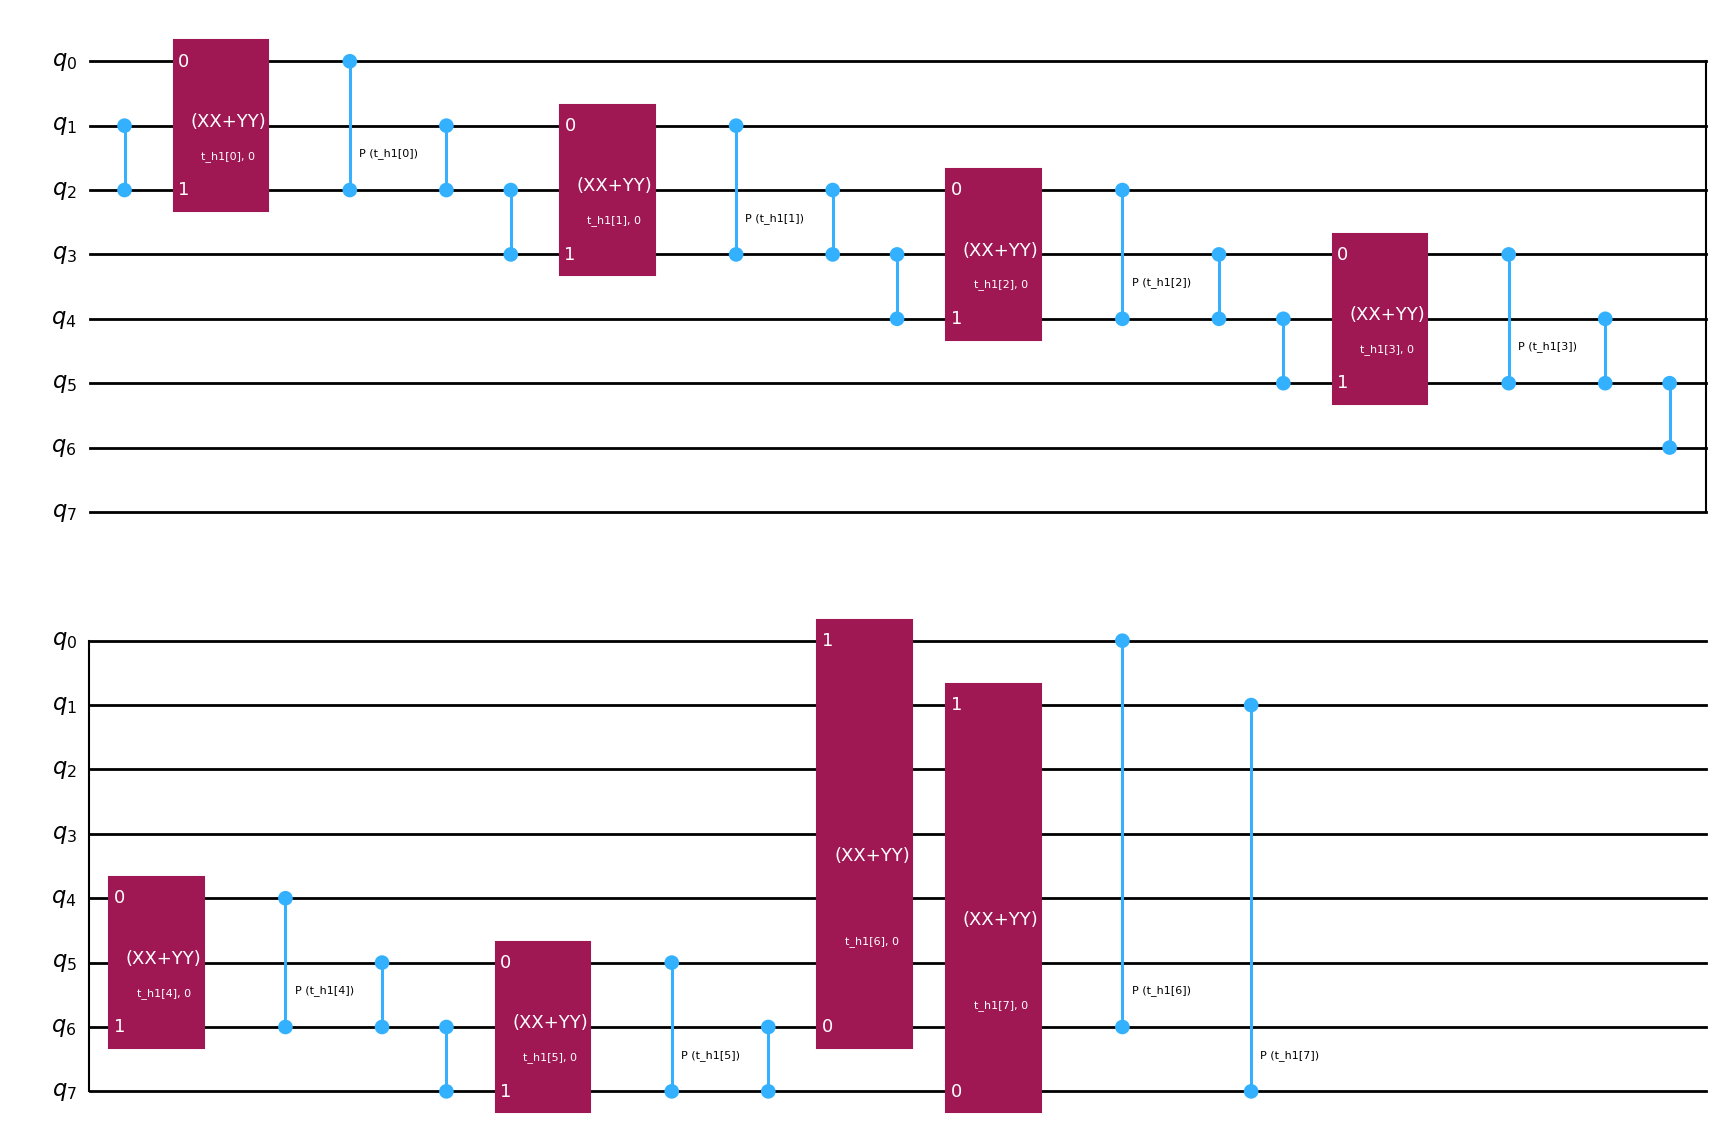

In [19]:
circ = QuantumCircuit(N)
hopping(circ,1)
circ.draw(output="mpl", style="iqp")

In [20]:
ans_hop = QuantumCircuit(N)
start2(ans_hop)
ans_hop.draw(style = "mpl")

┌───┐ ░ 
q_0: ┤ X ├─░─
     └───┘ ░ 
q_1: ──────░─
     ┌───┐ ░ 
q_2: ┤ X ├─░─
     └───┘ ░ 
q_3: ──────░─
           ░ 
q_4: ──────░─
     ┌───┐ ░ 
q_5: ┤ X ├─░─
     └───┘ ░ 
q_6: ──────░─
     ┌───┐ ░ 
q_7: ┤ X ├─░─
     └───┘ ░

In [21]:
hopint(ans_hop,reps = 3)

In [22]:
ans_h = QuantumCircuit(N)
start2(ans_hop)
ans_h.append(ExcitationPreserving(num_qubits=N, mode = "fsim", entanglement = t_list,reps = 2),[i for i in range(N)])

In [23]:
vqe = VQE(backend,ans_h,cost_func,optimizer='cobyla')

In [24]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
res = vqe.compute_minimum_eigenvalue(hamiltonian = qubit_jw_op,maxiter = 500)

Running with 56 parameters
Running with the following ansatz:


/Users/batuyalcin/anaconda3/envs/QiskitNew/lib/python3.11/site-packages/qiskit/providers/fake_provider/generic_backend_v2.py:506: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


Iters. done: 50 [Current cost: -0.0380859375]
Iters. done: 100 [Current cost: 0.0078125]
Iters. done: 150 [Current cost: 0.045166015625]
Iters. done: 200 [Current cost: -0.010498046875]
Iters. done: 250 [Current cost: 0.009033203125]
Iters. done: 300 [Current cost: 0.073486328125]
Iters. done: 350 [Current cost: 0.027099609375]
Iters. done: 400 [Current cost: 0.00537109375]


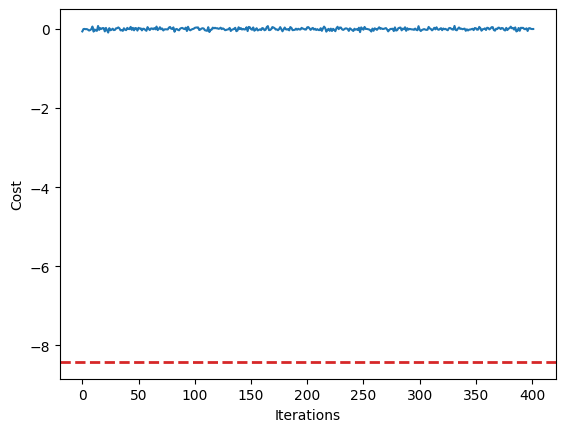

In [25]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.axhline(y=eig, color="tab:red", ls="--", lw=2, label="Target: " + str(eig))
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [26]:
def commutator(op1, op2):
    return op1 @ op2 - op2 @ op1
    
class AdaptVQE:

    def __init__(self,backend,ansatz:EvolvedOperatorAnsatz = None, cost_f=None, optimizer = "cobyla",estimator = None,shots = 1024,eps = 1e-5):
        if not isinstance(ansatz,EvolvedOperatorAnsatz):
            raise Exception("Ansatz is not of type EvolvedOperatorAnsatz")
        self.operator_pool = ansatz.operators
        #initial_circuit = ansatz.initial_state
        self.eps = eps
        self._tmp_ansatz = None
        self.op_indices = []
        self.op_list = []
        self.solver = VQE(backend=backend,ansatz=ansatz,cost_f=cost_f,optimizer=optimizer,estimator=estimator,shots = shots)
        
    def compute_gradient(self,params,ham,op):
        comm = 1j*commutator(ham,op)
        #print("Commutator is",comm)
        pub = (self.solver.pm_ansatz, [comm], [params])
        #print("Ansatz is", self.solver.pm_ansatz)
        result = self.solver.estimator.run(pubs=[pub]).result()
        grad = result[0].data.evs[0]
        return grad
    
    def select_op(self,params,ham):
        max_grad_op = None
        max_grad = 0
        max_grad_ind = 0
        for i,op in enumerate(self.operator_pool):
            grad = self.compute_gradient(params,ham,op)
            #print("Gradient",i,"is", grad)
            grad = np.abs(grad)
            #print("With absolute value",grad)
            if grad > max_grad:
                max_grad = grad
                max_grad_ind = i
                max_grad_op = op
        if max_grad<self.eps:
            return "AdaptVQE Converged"
        return max_grad_ind,max_grad_op
    
    def compute_adapt_eigenvalue(self,ham,aux_operators = []):
        cost_history_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
        }
        CONVERGED = False
        print(type(self.solver.ansatz))
        self._tmp_ansatz = self.solver.ansatz
        self.operator_pool = self._tmp_ansatz.operators
        self.solver.ansatz = self._tmp_ansatz.initial_state
        self.solver.pass_manage_ansatz()
        params = [] + [0.0]*self.solver.num_params
        history = []
        i=0
        res = None
        while not CONVERGED:
            print("Iteration",i)
            ind,op = self.select_op(params,ham)
            if isinstance(op,str):
                print(op)
                return res
            self.op_list.append(op)
            self.op_indices.append(ind)
            self._tmp_ansatz.operators = self.op_list
            self.solver.ansatz = self._tmp_ansatz
            params.append(0.0)
            self.solver.x0 = params
            self.solver.pass_manage_ansatz()
            res = self.solver.compute_minimum_eigenvalue(ham)
            params = list(res.x)
            history.append(res.fun)
            print("Operator indices",self.op_indices)
            print("Eigenvalue:",res.fun)
            i+=1
        return res


In [27]:
from qiskit.quantum_info import Pauli, PauliList, SparsePauliOp

def makePauliStr(N,idx,gs):
    pauli_str = ""
    for i in range(N):
        if i in idx:
            pauli_str+=gs[idx.index(i)]
        else:
            pauli_str+="I"
    return pauli_str

def ZZ(N,i,j):
    zz_str = makePauliStr(N,(i,j),["Z","Z"])
    return SparsePauliOp([zz_str],coeffs = [.5])

def dZZ(N,i,j,k,l):
    zz_str = makePauliStr(N,(i,j,k,l),["Z","Z","Z","Z"])
    return SparsePauliOp([zz_str],coeffs = [.5])

def XXplusYY(N,i,j):
    xx_str = makePauliStr(N,(i,j),["X","X"])
    yy_str = makePauliStr(N,(i,j),["Y","Y"])
    return SparsePauliOp([xx_str,yy_str],coeffs = [.25,.25])

def dXXplusYY(N,i,j,k,l):
    ij = XXplusYY(N,i,j)
    kl = XXplusYY(N,k,l)
    return ij@kl

print(ZZ(5,1,3))
print(dXXplusYY(5,1,3,2,4))


SparsePauliOp(['IZIZI'],
              coeffs=[0.5+0.j])
SparsePauliOp(['IXXXX', 'IXYXY', 'IYXYX', 'IYYYY'],
              coeffs=[0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j])


In [28]:
def poolXXYY(N,ts):
    pool = []
    for i,edge in enumerate(ts):
        p = XXplusYY(N,edge[0],edge[1])
        #print(isinstance(p,Operator))
        pool.append(p)
    return pool

def pooldXXYY(N,ts):
    pool = []
    for i,edge in enumerate(ts):
        for j in range(i):
            p = dXXplusYY(N,edge[0],edge[1],ts[j][0],ts[j][1])
            #print(isinstance(p,Operator))
            pool.append(p)
    return pool

def poolZZ(N,Us):
    pool = []
    for edge in Us:
        p = ZZ(N,edge[0],edge[1])
        pool.append(p)
    return pool

def pooldZZ(N,Us):
    pool = []
    for i,edge in enumerate(Us):
        for j in range(i):
            p = dZZ(N,edge[0],edge[1],Us[j][0],Us[j][1])
            #print(isinstance(p,Operator))
            pool.append(p)
    return pool

def totalPool(N,Us,ts):
    ZZ = poolZZ(N,Us)
    dZZ = pooldZZ(N,Us)
    XXYY = poolXXYY(N,ts)
    dXXYY = pooldXXYY(N,ts)
    return XXYY + ZZ + dXXYY + dZZ

pool = totalPool(N,t_list,U_list)
print(pool)

[SparsePauliOp(['XXIIIIIIIIII', 'YYIIIIIIIIII'],
              coeffs=[0.25+0.j, 0.25+0.j]), SparsePauliOp(['IIXXIIIIIIII', 'IIYYIIIIIIII'],
              coeffs=[0.25+0.j, 0.25+0.j]), SparsePauliOp(['IIIIXXIIIIII', 'IIIIYYIIIIII'],
              coeffs=[0.25+0.j, 0.25+0.j]), SparsePauliOp(['IIIIIIXXIIII', 'IIIIIIYYIIII'],
              coeffs=[0.25+0.j, 0.25+0.j]), SparsePauliOp(['IIIIIIIIXXII', 'IIIIIIIIYYII'],
              coeffs=[0.25+0.j, 0.25+0.j]), SparsePauliOp(['IIIIIIIIIIXX', 'IIIIIIIIIIYY'],
              coeffs=[0.25+0.j, 0.25+0.j]), SparsePauliOp(['ZIZIIIIIIIII'],
              coeffs=[0.5+0.j]), SparsePauliOp(['IZIZIIIIIIII'],
              coeffs=[0.5+0.j]), SparsePauliOp(['IIZIZIIIIIII'],
              coeffs=[0.5+0.j]), SparsePauliOp(['IIIZIZIIIIII'],
              coeffs=[0.5+0.j]), SparsePauliOp(['IIIIZIZIIIII'],
              coeffs=[0.5+0.j]), SparsePauliOp(['IIIIIZIZIIII'],
              coeffs=[0.5+0.j]), SparsePauliOp(['IIIIIIZIZIII'],
              coeffs=[0.5

In [29]:
def s_circ(N):
    qc = QuantumCircuit(N)
    li = [i for i in range(0,N//2,2)]+[N-1-i for i in range(0,N//2,2)]
    print(li)
    qc.x(li)
    qc.barrier()
    return qc



def s_circ2(N):
    circ = QuantumCircuit(N)
    li = [i for i in range(0,N,4)]+[i+1 for i in range(0,N,4)]
    for i in li:
        circ.x(i)
        circ.x(i+2)
        circ.h(i+2)
        circ.cx(i,i+2)
    circ.barrier()
    return circ

ans = EvolvedOperatorAnsatz(pool,initial_state=s_circ(N),parameter_prefix="b")
ans1 = EvolvedOperatorAnsatz(pool,initial_state=ans)
print(ans.initial_state.decompose())
print(s_circ(N))


[0, 2, 4, 11, 9, 7]
      ┌───────────┐ ░ 
 q_0: ┤ U3(π,0,π) ├─░─
      └───────────┘ ░ 
 q_1: ──────────────░─
      ┌───────────┐ ░ 
 q_2: ┤ U3(π,0,π) ├─░─
      └───────────┘ ░ 
 q_3: ──────────────░─
      ┌───────────┐ ░ 
 q_4: ┤ U3(π,0,π) ├─░─
      └───────────┘ ░ 
 q_5: ──────────────░─
                    ░ 
 q_6: ──────────────░─
      ┌───────────┐ ░ 
 q_7: ┤ U3(π,0,π) ├─░─
      └───────────┘ ░ 
 q_8: ──────────────░─
      ┌───────────┐ ░ 
 q_9: ┤ U3(π,0,π) ├─░─
      └───────────┘ ░ 
q_10: ──────────────░─
      ┌───────────┐ ░ 
q_11: ┤ U3(π,0,π) ├─░─
      └───────────┘ ░ 
[0, 2, 4, 11, 9, 7]
      ┌───┐ ░ 
 q_0: ┤ X ├─░─
      └───┘ ░ 
 q_1: ──────░─
      ┌───┐ ░ 
 q_2: ┤ X ├─░─
      └───┘ ░ 
 q_3: ──────░─
      ┌───┐ ░ 
 q_4: ┤ X ├─░─
      └───┘ ░ 
 q_5: ──────░─
            ░ 
 q_6: ──────░─
      ┌───┐ ░ 
 q_7: ┤ X ├─░─
      └───┘ ░ 
 q_8: ──────░─
      ┌───┐ ░ 
 q_9: ┤ X ├─░─
      └───┘ ░ 
q_10: ──────░─
      ┌───┐ ░ 
q_11: ┤ X ├─░─
      └───┘ ░ 


In [30]:
adapt_vqe = AdaptVQE(backend,ans,cost_func,optimizer='cobyla')

In [31]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
res = adapt_vqe.compute_adapt_eigenvalue(ham = qubit_jw_op)

<class 'qiskit.circuit.library.n_local.evolved_operator_ansatz.EvolvedOperatorAnsatz'>
Iteration 0
Running with 1 parameters
Running with the following ansatz:
Operator indices [64]
Eigenvalue: -8.998046875
Iteration 1
Running with 2 parameters
Running with the following ansatz:
Operator indices [64, 90]
Eigenvalue: -8.96142578125
Iteration 2
Running with 3 parameters
Running with the following ansatz:
Iters. done: 50 [Current cost: -8.9580078125]
Operator indices [64, 90, 35]
Eigenvalue: -9.01953125
Iteration 3
Running with 4 parameters
Running with the following ansatz:
Iters. done: 100 [Current cost: -8.917236328125]
Operator indices [64, 90, 35, 51]
Eigenvalue: -9.050048828125
Iteration 4
Running with 5 parameters
Running with the following ansatz:
Iters. done: 150 [Current cost: -9.002197265625]
Operator indices [64, 90, 35, 51, 53]
Eigenvalue: -9.060791015625
Iteration 5
Running with 6 parameters
Running with the following ansatz:
Iters. done: 200 [Current cost: -9.033935546875]


KeyboardInterrupt: 